In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from api import SpotifyAPI

## Aquisição e conversão dos dados

* Aquisição dos arquivos CSV obtidos do site Spotify Charts
* Conversão do data type dos dataframes
* Visualização inicial da tabela

In [2]:
# aquisição dos dados do spotify charts
dfs = []
for country in ['global', 'br', 'us', 'sa', 'jp']:
    path = f'data/regional_{country}_daily_latest.csv'
    dfs.append(pd.read_csv(path, sep=';').drop(['img'], axis=1))

In [3]:
# função que transforma o dtype da tabela
def cast(row):
    a, b, c, d, e = row[['url', 'position', 'track', 'artists', 'streams']].values
    d = d.replace('[', '').replace(']', '').replace("'", '').split(', ')
    return pd.Series({'url': str(a),
                      'position': int(b),
                      'track': str(c),
                      'artists': d,
                      'streams': int(e)})

In [4]:
# aplica a função nos dataframes
world, br, us, sa, jp = [x.apply(cast, axis=1) for x in dfs]

In [25]:
# lista com todos os dataframes
dfs = [world, br, us, sa, jp]
regions = ['Mundo', 'Brasil', 'EUA', 'KSA', 'Japão']

In [6]:
world.head()

,url,position,track,artists,streams
0,https://open.spotify.com/track/5PjdY0CKGZdEuoN...,1,STAY (with Justin Bieber),[The Kid LAROI],9218788
1,https://open.spotify.com/track/27NovPIUIRrOZoC...,2,INDUSTRY BABY (feat. Jack Harlow),[Lil Nas X],5803231
2,https://open.spotify.com/track/3Wrjm47oTz2sjIg...,3,Beggin',[Måneskin],5591945
3,https://open.spotify.com/track/6PQ88X9TkUIAUIZ...,4,Bad Habits,[Ed Sheeran],5192794
4,https://open.spotify.com/track/4ZtFanR9U6ndgdd...,5,good 4 u,[Olivia Rodrigo],4851132


## API de busca da descrição de uma música

In [7]:
# instancia um objeto searcher da classe SpotifyAPI()
searcher = SpotifyAPI()

## Número de repetições entre as 200 mais tocadas

* Identificação das regiões que mais utilizam o Spotify

In [8]:
# número de repetições por região
streams = []
for df in dfs:
    stream = df['streams'].sum()
    streams.append(stream)
    print(stream)

271922802
40331467
68911289
870729
12430986


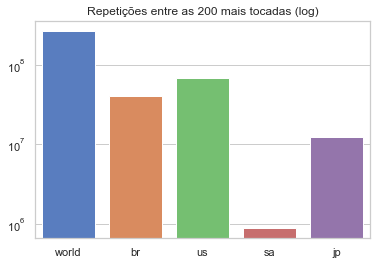

In [70]:
# gráfico do número de repetições entre as 200 músicas mais tocadas
sea.set_theme(style='whitegrid')
sea.set_palette('muted')
sea.barplot(x=['world', 'br', 'us', 'sa', 'jp'], y=streams, log=True)
plt.title('Repetições entre as 200 mais tocadas (log)')
plt.show()

## Repetições por música

* Análise do número de streams por posição da música

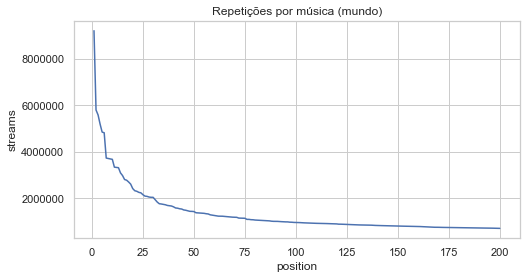

In [10]:
# Predominância de uma música sobre as outras (mundo)
plt.figure(figsize=[8, 4])
sea.lineplot(data=world, x='position', y='streams')
plt.title('Repetições por música (mundo)')
plt.show()

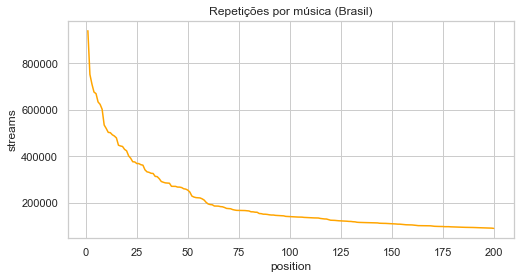

In [11]:
# Predominância de uma música sobre as outras (mundo)
plt.figure(figsize=[8, 4])
sea.lineplot(data=br, x='position', y='streams', color='orange')
plt.title('Repetições por música (Brasil)')
plt.show()

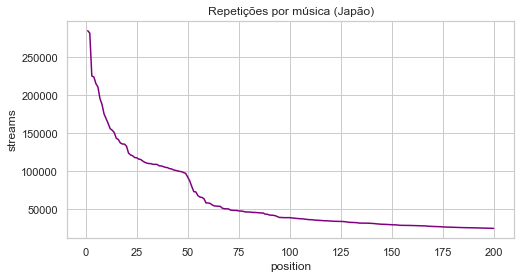

In [12]:
# Predominância de uma música sobre as outras (mundo)
plt.figure(figsize=[8, 4])
sea.lineplot(data=jp, x='position', y='streams', color='purple')
plt.title('Repetições por música (Japão)')
plt.show()

## Modelagem da popularidade das músicas

* Modelagem exponencial da curva de popularidade das músicas
* Uso do método scipy.optimize.curve_fit()

In [13]:
# função modelo 1
def exponential_1(x, a, b, c, d):
    return a*np.exp(-x/b + c) + d

# função modelo 2
def exponential_2(x, a, b, c, d):
    return a*np.exp(-x/b + c) + d/x

In [14]:
# exponential fit
popt_1, pcov_1 = scipy.optimize.curve_fit(exponential_1, np.array(range(1, 201)), np.array(world['streams']))
popt_2, pcov_2 = scipy.optimize.curve_fit(exponential_2, np.array(range(1, 201)), np.array(world['streams']))

In [15]:
# parametros do fit
print(popt_1)
print(popt_2)

[3.75507158e+02 1.58796502e+01 9.65147828e+00 9.10590434e+05]
[4.24182050e+01 1.07173487e+02 1.09712252e+01 7.62123319e+06]


In [16]:
# aplicando o fit nos dados
exp1_fit_world = [exponential_1(x, popt_1[0], popt_1[1], popt_1[2], popt_1[3]) for x in range(1, 201)]
exp2_fit_world = [exponential_2(x, popt_2[0], popt_2[1], popt_2[2], popt_2[3]) for x in range(1, 201)]

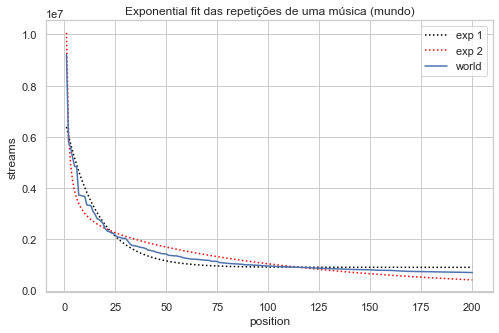

In [17]:
# comparação do fit com os dados reais
plt.figure(figsize=[8, 5])
sea.lineplot(x=range(1, 201), y=exp1_fit_world, color='black', linestyle=':')
sea.lineplot(x=range(1, 201), y=exp2_fit_world, color='red', linestyle=':')
sea.lineplot(data=world, x='position', y='streams')
plt.title('Exponential fit das repetições de uma música (mundo)')
plt.legend(['exp 1', 'exp 2', 'world'])
plt.show()

## Artistas mais tocados no mundo

* Identificação dos artistas que tem mais músicas entre as 200 mais tocadas em uma região
* Esses devem ser os cantores/grupos com maior popularidade no momento, mesmo que a música mais tocada não seja deles.

In [47]:
# função que encontra os 5 artistas com mais músicas populares em uma região
def most_popular(df, region):
    artists = []
    for list_artists in df['artists']:
        for artist in list_artists:
            artists.append(artist)
    
    counter = []
    for artist in artists:
        if [artist, artists.count(artist)] not in counter:
            counter.append([artist, artists.count(artist)])
    
    counter.sort(key=lambda x:x[1], reverse=True)
    
    return [[x[0] for x in counter[:5]], [x[1] for x in counter[:5]]]

In [50]:
# artistas mais repetidos em cada região
popular = []
for x, y in zip(dfs, regions):
    result = most_popular(x, y)
    popular.append(result)
    print('# ' + y + ':\n' + str(result))

# Mundo:
[['Billie Eilish', 'Olivia Rodrigo', 'Doja Cat', 'The Weeknd', 'Bad Bunny'], [12, 9, 7, 6, 6]]
# Brasil:
[['João Gomes', 'Os Barões Da Pisadinha', 'Luísa Sonza', 'Tarcísio do Acordeon', 'Olivia Rodrigo'], [11, 9, 8, 7, 7]]
# EUA:
[['Billie Eilish', 'Olivia Rodrigo', 'Doja Cat', 'The Weeknd', 'Juice WRLD'], [13, 10, 7, 6, 6]]
# KSA:
[['Abdullah Al Farwan', 'Ariana Grande', 'غريب ال مخلص', 'Olivia Rodrigo', 'Travis Scott'], [8, 7, 6, 6, 6]]
# Japão:
[['BTS', 'YOASOBI', 'Official HIGE DANdism', 'Kenshi Yonezu', 'Vaundy'], [15, 15, 11, 8, 7]]


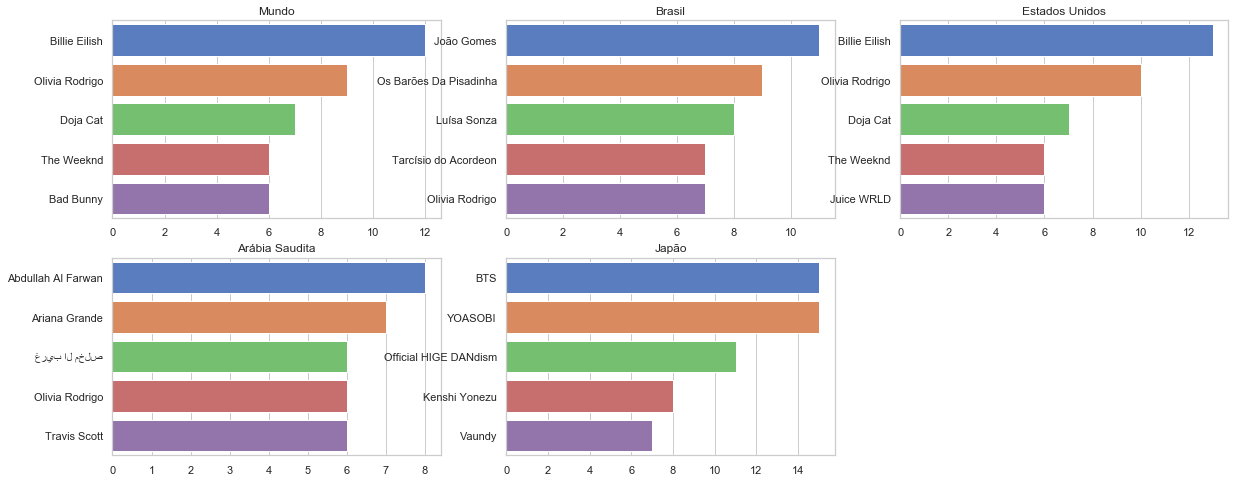

In [83]:
# visualização gráfica
plt.figure(figsize=[20, 8])
plt.subplot(2, 3, 1)
sea.barplot(y=popular[0][0], x=popular[0][1])
plt.title('Mundo')
plt.subplot(2, 3, 2)
sea.barplot(y=popular[1][0], x=popular[1][1])
plt.title('Brasil')
plt.subplot(2, 3, 3)
sea.barplot(y=popular[2][0], x=popular[2][1])
plt.title('Estados Unidos')
plt.subplot(2, 3, 4)
sea.barplot(y=popular[3][0], x=popular[3][1])
plt.title('Arábia Saudita')
plt.subplot(2, 3, 5)
sea.barplot(y=popular[4][0], x=popular[4][1])
plt.title('Japão')
plt.show()

## Características dos artistas preferidos por país